<a href="https://colab.research.google.com/github/beatrizdsantosss/cifo-project/blob/main/CIFO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image
import numpy as np
from PIL import Image
import random
import numpy as np
from PIL import Image
import random
from copy import copy
from operator import attrgetter
from random import randint, sample, choice, uniform
from math import exp

image = Image.open('target_image.jpg').convert('RGB')

new_width=150
new_height=100

target_image = image.resize((new_width, new_height), Image.ANTIALIAS)

target_array = np.array(target_image)

<ipython-input-2-7b3ee7036c4f>:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  target_image = image.resize((new_width, new_height), Image.ANTIALIAS)


In [ ]:
import numpy as np
import random
from PIL import Image
from skimage.color import deltaE_cie76, rgb2lab
from copy import copy
from operator import attrgetter
from random import choice

class Individual:
    def __init__(self, representation=None):
        self.representation = representation
        self.fitness = self.get_fitness()

    def get_fitness(self):
        raise NotImplementedError("You need to implement the get_fitness method.")

class ColorIndividual(Individual):
    def __init__(self, representation, target_array):
        self.representation = representation
        self.target_array = target_array
        self.array = self.representation  # Assuming self.array is a representation of the image
        self.fitness = self.get_fitness_euclidean(target_array)

    def get_fitness_euclidean(self, target_array):
        # Convert RGB images to Lab color space for better perceptual accuracy
        target_lab = rgb2lab(target_array)
        array_lab = rgb2lab(self.array)
        diff_array = deltaE_cie76(target_lab, array_lab)
        self.fitness = np.mean(diff_array)
        return self.fitness

def gaussian_mutation(individual, mutation_rate, sigma):
    mutated_repr = individual.representation.copy()
    for i in range(mutated_repr.shape[0]):
        for j in range(mutated_repr.shape[1]):
            if random.random() < mutation_rate:
                # Sample changes from a Gaussian distribution
                delta = np.random.normal(scale=sigma, size=3)
                mutated_repr[i, j] = np.clip(mutated_repr[i, j] + delta, 0, 255)
    return ColorIndividual(mutated_repr, individual.target_array)

def crossover(parent1_repr, parent2_repr):
    point = random.randint(0, parent1_repr.shape[0] - 1)
    child1_repr = np.concatenate((parent1_repr[:point], parent2_repr[point:]), axis=0)
    child2_repr = np.concatenate((parent2_repr[:point], parent1_repr[point:]), axis=0)
    return child1_repr, child2_repr

class Population:
    def __init__(self, size, optim):
        self.size = size
        self.optim = optim
        self.individuals = []

    def evolve(self, gens, xo_prob, mut_prob, select, xo, mutate, elitism):
        for i in range(gens):
            new_pop = []
            if elitism:
                elite = copy(min(self.individuals, key=attrgetter('fitness')))

            while len(new_pop) < self.size:
                parent1, parent2 = select(self), select(self)
                if random.random() < xo_prob:
                    offspring1_repr, offspring2_repr = xo(parent1.representation, parent2.representation)
                else:
                    offspring1_repr, offspring2_repr = parent1.representation, parent2.representation

                if random.random() < mut_prob:
                    offspring1_repr = mutate(ColorIndividual(representation=offspring1_repr, target_array=target_array), mut_prob, sigma=20).representation
                if random.random() < mut_prob:
                    offspring2_repr = mutate(ColorIndividual(representation=offspring2_repr, target_array=target_array), mut_prob, sigma=20).representation

                new_pop.append(ColorIndividual(representation=offspring1_repr, target_array=target_array))
                if len(new_pop) < self.size:
                    new_pop.append(ColorIndividual(representation=offspring2_repr, target_array=target_array))

            if elitism:
                worst = max(new_pop, key=attrgetter('fitness'))
                if elite.fitness < worst.fitness:
                    new_pop.pop(new_pop.index(worst))
                    new_pop.append(elite)

            self.individuals = new_pop
            print(f"Best fitness of gen #{i + 1}: {min(self.individuals, key=attrgetter('fitness')).fitness}")

    def __len__(self):
        return len(self.individuals)

    def __getitem__(self, position):
        return self.individuals[position]

class ColorPopulation(Population):
    def __init__(self, size, optim, target_array, **kwargs):
        super().__init__(size, optim)
        self.target_array = target_array
        self.individuals = [ColorIndividual(representation=np.random.randint(0, 256, target_array.shape, dtype=np.uint8), target_array=target_array) for _ in range(size)]

# Create a population
population_size = 100
mutation_rate = 0.01
generations = 5000
xo_prob = 0.7
elitism = True

population = ColorPopulation(size=population_size, optim="min", target_array=target_array)

def tournament_sel(population, tour_size=3):
    tournament = [choice(population) for _ in range(tour_size)]
    return min(tournament, key=attrgetter('fitness'))

def selection(pop):
    return tournament_sel(pop, tour_size=3)

population.evolve(
    gens=generations,
    xo_prob=xo_prob,
    mut_prob=mutation_rate,
    select=selection,
    xo=crossover,
    mutate=lambda ind, mut_rate, sigma: gaussian_mutation(ind, mut_rate, sigma),
    elitism=elitism
)

best_individual = min(population.individuals, key=attrgetter('fitness')).representation
best_image = Image.fromarray(best_individual)


Best fitness of gen #1: 71.54227916500956
Best fitness of gen #2: 71.48948857623715
Best fitness of gen #3: 71.28635948943331
Best fitness of gen #4: 71.10680235383653
Best fitness of gen #5: 71.06345940455579
Best fitness of gen #6: 70.81768238277812
Best fitness of gen #7: 70.81768238277812
Best fitness of gen #8: 70.80815086585767
Best fitness of gen #9: 70.7742163387185
Best fitness of gen #10: 70.7309572668665
Best fitness of gen #11: 70.7213445657961
Best fitness of gen #12: 70.69390810327202
Best fitness of gen #13: 70.69390810327202
Best fitness of gen #14: 70.68220100398162
Best fitness of gen #15: 70.67403241320301
Best fitness of gen #16: 70.65805142178334
Best fitness of gen #17: 70.64634432249292
Best fitness of gen #18: 70.64058340190792
Best fitness of gen #19: 70.5864211630309
Best fitness of gen #20: 70.58465614503199
Best fitness of gen #21: 70.56501192272314
Best fitness of gen #22: 70.5391998563273
Best fitness of gen #23: 70.51779061601955
Best fitness of gen #24: 

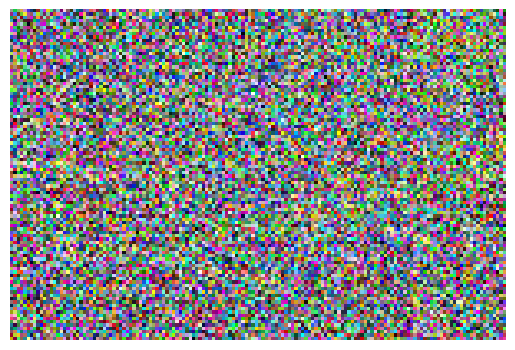

In [ ]:
import matplotlib.pyplot as plt

# Assuming best_individual contains the pixel values of the best image
# Display the image using Matplotlib
plt.imshow(best_individual)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.color import deltaE_cie76, rgb2lab
from copy import deepcopy, copy
from operator import attrgetter

class Triangle:
    def __init__(self, img_width, img_height):
        self._img_width = img_width
        self._img_height = img_height
        x = random.randint(0, int(img_width))
        y = random.randint(0, int(img_height))

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = (
            random.randint(0, 256),
            random.randint(0, 256),
            random.randint(0, 256),
            random.randint(0, 256)
        )

    def mutate(self, sigma=1.0):
        mutations = ['shift', 'point', 'color', 'reset']
        weights = [30, 35, 30, 5]
        mutation_type = random.choices(mutations, weights=weights, k=1)[0]

        if mutation_type == 'shift':
            x_shift = int(random.randint(-50, 50) * sigma)
            y_shift = int(random.randint(-50, 50) * sigma)
            self.points = [(x + x_shift, y + y_shift) for x, y in self.points]
        elif mutation_type == 'point':
            index = random.choice(list(range(len(self.points))))
            self.points[index] = (
                self.points[index][0] + int(random.randint(-50, 50) * sigma),
                self.points[index][1] + int(random.randint(-50, 50) * sigma),
            )
        elif mutation_type == 'color':
            self.color = tuple(
                c + int(random.randint(-50, 50) * sigma) for c in self.color
            )
            self.color = tuple(
                min(max(c, 0), 255) for c in self.color
            )
        else:
            new_triangle = Triangle(self._img_width, self._img_height)
            self.points = new_triangle.points
            self.color = new_triangle.color

class Painting:
    def __init__(self, num_triangles, img_width, img_height):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)

        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)

        return image


    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            if random.random() < mutation_rate:
                triangle.mutate()

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('RGB'))
    rendered_image = np.array(painting.draw().convert('RGB'))
    target_lab = rgb2lab(target_array)
    rendered_lab = rgb2lab(rendered_image)
    diff_array = deltaE_cie76(target_lab, rendered_lab)
    return np.mean(diff_array)

def crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    crossover_point = random.randint(0, len(parent1.triangles))
    child1.triangles[crossover_point:], child2.triangles[crossover_point:] = (
        parent2.triangles[crossover_point:], parent1.triangles[crossover_point:])

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.individuals = [Painting(num_triangles, img_width, img_height) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Load target image
target_image_path = 'target_image.jpg'
target_image = Image.open(target_image_path).convert('RGB')
img_width, img_height = target_image.size

# Parameters
population_size = 50
num_triangles = 100
generations = 1000
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# Initialize and evolve population
population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image)
population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]
best_image = best_individual.draw()




Generation 1, Best Fitness: 63.85443482118962
Generation 2, Best Fitness: 63.37511362525653
Generation 3, Best Fitness: 63.07979604180581
Generation 4, Best Fitness: 63.03479625026369
Generation 5, Best Fitness: 62.29994847192134
Generation 6, Best Fitness: 62.151050711775504
Generation 7, Best Fitness: 61.87005169663821
Generation 8, Best Fitness: 61.653243020480915
Generation 9, Best Fitness: 61.127051103871054
Generation 10, Best Fitness: 60.902446329127876
Generation 11, Best Fitness: 60.70670351791963
Generation 12, Best Fitness: 60.39109315475334
Generation 13, Best Fitness: 60.39109315475334
Generation 14, Best Fitness: 60.31407540263581
Generation 15, Best Fitness: 60.11229731451154
Generation 16, Best Fitness: 60.00139526442396
Generation 17, Best Fitness: 59.96772548348049
Generation 18, Best Fitness: 59.570768933982556
Generation 19, Best Fitness: 59.204905608853544
Generation 20, Best Fitness: 59.204905608853544
Generation 21, Best Fitness: 59.03400685865296
Generation 22, 

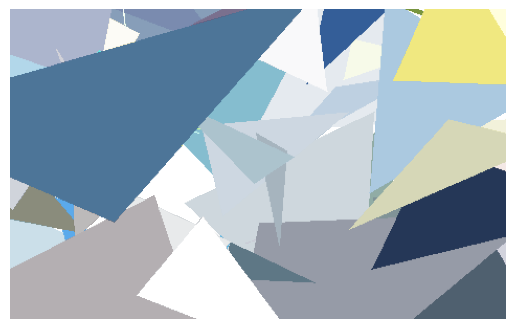

In [ ]:
import matplotlib.pyplot as plt

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

# Convert the best individual to an image
best_image = best_individual.draw()

# Convert the image to a format suitable for plt.imshow
best_image_array = np.array(best_image)

# Display the image using Matplotlib
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()


Generation 1, Best Fitness: 64.91270770595293
Generation 2, Best Fitness: 64.79316489383064
Generation 3, Best Fitness: 64.70577228666724
Generation 4, Best Fitness: 64.56792128502724
Generation 5, Best Fitness: 64.41111440599904
Generation 6, Best Fitness: 64.41111440599904
Generation 7, Best Fitness: 64.3600920676927
Generation 8, Best Fitness: 64.15161943092546
Generation 9, Best Fitness: 64.15161943092546
Generation 10, Best Fitness: 63.89045022724677
Generation 11, Best Fitness: 63.89045022724677
Generation 12, Best Fitness: 63.87232661941128
Generation 13, Best Fitness: 63.81438159701973
Generation 14, Best Fitness: 63.77689040850939
Generation 15, Best Fitness: 63.758149813800685
Generation 16, Best Fitness: 63.733699006281086
Generation 17, Best Fitness: 63.64303817827123
Generation 18, Best Fitness: 63.63863894407312
Generation 19, Best Fitness: 63.45007599375461
Generation 20, Best Fitness: 63.30511614734532
Generation 21, Best Fitness: 63.30511614734532
Generation 22, Best F

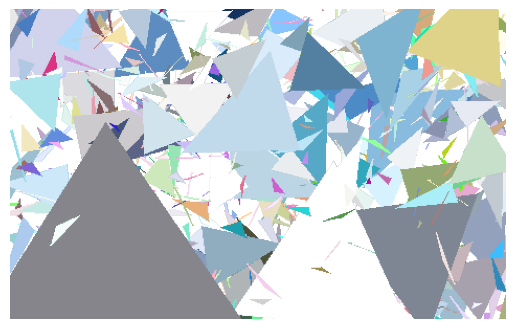

In [ ]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.color import deltaE_cie76, rgb2lab
from copy import deepcopy, copy
from operator import attrgetter

class Triangle:
    def __init__(self, img_width, img_height):
        self._img_width = img_width
        self._img_height = img_height
        x = random.randint(0, int(img_width))
        y = random.randint(0, int(img_height))

        self.points = [
            (x + random.randint(-10, 10), y + random.randint(-10, 10)),
            (x + random.randint(-10, 10), y + random.randint(-10, 10)),
            (x + random.randint(-10, 10), y + random.randint(-10, 10))
        ]
        self.color = (
            random.randint(0, 256),
            random.randint(0, 256),
            random.randint(0, 256),
            random.randint(0, 256)
        )

    def mutate(self, sigma=1.0):
        mutations = ['shift', 'point', 'color', 'reset']
        weights = [30, 35, 30, 5]
        mutation_type = random.choices(mutations, weights=weights, k=1)[0]

        if mutation_type == 'shift':
            x_shift = int(random.randint(-20, 20) * sigma)
            y_shift = int(random.randint(-20, 20) * sigma)
            self.points = [(x + x_shift, y + y_shift) for x, y in self.points]
        elif mutation_type == 'point':
            index = random.choice(list(range(len(self.points))))
            self.points[index] = (
                self.points[index][0] + int(random.randint(-20, 20) * sigma),
                self.points[index][1] + int(random.randint(-20, 20) * sigma),
            )
        elif mutation_type == 'color':
            self.color = tuple(
                c + int(random.randint(-20, 20) * sigma) for c in self.color
            )
            self.color = tuple(
                min(max(c, 0), 255) for c in self.color
            )
        else:
            new_triangle = Triangle(self._img_width, self._img_height)
            self.points = new_triangle.points
            self.color = new_triangle.color

class Painting:
    def __init__(self, num_triangles, img_width, img_height):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)

        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)

        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            if random.random() < mutation_rate:
                triangle.mutate()

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('RGB'))
    rendered_image = np.array(painting.draw().convert('RGB'))
    target_lab = rgb2lab(target_array)
    rendered_lab = rgb2lab(rendered_image)
    diff_array = deltaE_cie76(target_lab, rendered_lab)
    return np.mean(diff_array)

def crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    crossover_point = random.randint(0, len(parent1.triangles))
    child1.triangles[crossover_point:], child2.triangles[crossover_point:] = (
        parent2.triangles[crossover_point:], parent1.triangles[crossover_point:])

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.individuals = [Painting(num_triangles, img_width, img_height) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

# Load target image
target_image_path = 'target_image.jpg'
target_image = Image.open(target_image_path).convert('RGB')
img_width, img_height = target_image.size

# Parameters
population_size = 50
num_triangles = 800  # Increased number of triangles
generations = 1000
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

# Initialize and evolve population
population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image)
population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

# Get the best individual
best_individual = population.individuals[population.fitness.index(min(population.fitness))]
best_image = best_individual.draw()

# Display the best image using Matplotlib
import matplotlib.pyplot as plt

best_image_array = np.array(best_image)
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()
